<a href="https://colab.research.google.com/github/ZacharyMalonjao/FinMark-Machine-Learning/blob/main/DMP_Datacleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



In [ ]:
feedback = pd.read_csv('https://raw.githubusercontent.com/ZacharyMalonjao/FinMark-Machine-Learning/refs/heads/main/DMP/Customer_Feedback_Data.csv')
transaction = pd.read_csv('https://raw.githubusercontent.com/ZacharyMalonjao/FinMark-Machine-Learning/refs/heads/main/DMP/Transaction_Data.csv')

#1. Clean Feedback table

## Customer ID

In [ ]:
#Delete Duplicates

feedback['Customer_ID'].isna().sum()
duplicate_counts = feedback['Customer_ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)


Customer_ID
37     13
959    12
106    11
509    11
280    11
       ..
187     2
210     2
136     2
122     2
194     2
Name: count, Length: 983, dtype: int64


In [ ]:
# Keep first occurrence of each Customer_ID
feedback = feedback.drop_duplicates(subset='Customer_ID', keep='first')


In [ ]:
duplicate_counts = feedback['Customer_ID'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print(duplicate_counts)


Series([], Name: count, dtype: int64)


## Satisfaction_Score and Likelihood_to_Recommend

Method:
* Median Imputation for Likelihood_to_recommend
* Satisfaction_score has no missing *and* outliers

In [ ]:
print(feedback['Satisfaction_Score'].isna().sum() )
print(feedback['Likelihood_to_Recommend'].isna().sum())

22
0


In [ ]:
def check_outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound= q1 - 1.5 * iqr
  upper_bound= q3 + 1.5 * iqr

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  return outliers


In [ ]:
check_outliers(feedback, 'Likelihood_to_Recommend')
#Satisfaction score has no outliers, nor missing values


,Customer_ID,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend


In [ ]:
check_outliers(feedback, 'Satisfaction_Score')

,Customer_ID,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend
529,530,52.0,Good service,10
573,574,60.0,Good service,9
857,858,56.0,Very satisfied,10


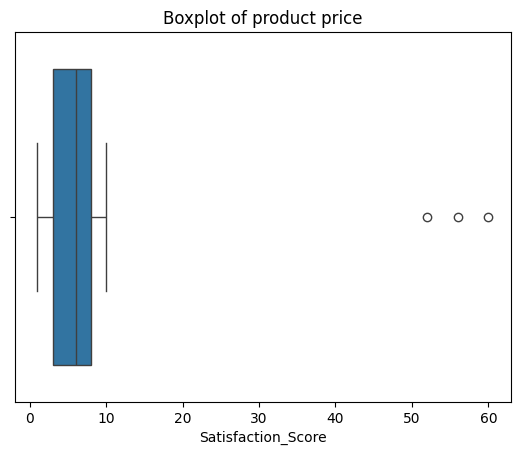

In [ ]:
sns.boxplot(x=feedback['Satisfaction_Score'])
plt.title('Boxplot of product price')
plt.show()

In [ ]:
#Turn outliers to NaN, impute median
feedback.loc[
    (feedback['Satisfaction_Score'] < 1) |
    (feedback['Satisfaction_Score'] > 10),
    'Satisfaction_Score'
] = np.nan



feedback['Satisfaction_Score']=feedback['Satisfaction_Score'].fillna(
    feedback['Satisfaction_Score'].median()
)

feedback['Satisfaction_Score'].between(1, 10).all()
feedback['Satisfaction_Score'].dtype

dtype('float64')

##Feedback_Comment

Method: Ordinal Integer Mapping

In [ ]:
feedback['Feedback_Comments'].astype(str).unique()


array(['Very satisfied', 'Needs improvement', 'Unsatisfactory',
       'Good service', 'Excellent'], dtype=object)

In [ ]:
feedback['Feedback_Comments'] = (
    feedback['Feedback_Comments']
    .str.lower()
    .str.strip()
)

In [ ]:
feedback['Feedback_Comments'].isna().sum()


np.int64(0)

In [ ]:
feedback['Feedback_Comments'].value_counts()

,count
Feedback_Comments,
good service,276
needs improvement,213
unsatisfactory,203
very satisfied,197
excellent,111


In [ ]:
order = {
     'excellent': 4,
    'very satisfied': 3,
    'good service': 2,
    'needs improvement': 1,
    'unsatisfactory': 0
     }
feedback['Feedback_Comments'] = feedback['Feedback_Comments'].map(order)

feedback['Feedback_Comments'].value_counts()

,count
Feedback_Comments,
2,276
1,213
0,203
3,197
4,111


# 2. Clean Transcation Table


## 2.1 Transaction_ID

In [ ]:
print(transaction['Transaction_ID'].isna().sum())


print(transaction['Transaction_ID'].duplicated().sum())
transaction = transaction.drop_duplicates(subset='Transaction_ID', keep = 'first')
print(transaction['Transaction_ID'].duplicated().sum())

0
50
0


## 2.2 Customer_ID

In [ ]:
transaction = transaction.dropna(subset=['Customer_ID'])
valid_customers = set(feedback['Customer_ID'])
transaction = transaction[transaction['Customer_ID'].isin(valid_customers)]


##2.3 Transaction_Date


In [ ]:
transaction=transaction.drop(columns=['Transaction_Date'])

## 2.4 Transaction_Amount

In [ ]:
transaction['Transaction_Amount'].isna().sum()
(transaction['Transaction_Amount'] < 0).sum()


np.int64(0)

In [ ]:
#Outliers (Keep them because it's normal in transaction data)

Q1 = transaction['Transaction_Amount'].quantile(0.25)
Q3 = transaction['Transaction_Amount'].quantile(0.75)
IQR = Q3-Q1

lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3 + 1.5*IQR

outliers = (transaction['Transaction_Amount'] < lower_bound) | (transaction['Transaction_Amount'] > upper_bound)

print(transaction[outliers])

      Transaction_ID  Customer_ID  Transaction_Amount Transaction_Type
612              613          191            480300.0     Bill Payment
1264            1265          772            390200.0     Bill Payment
1738            1739           27            194500.0     Bill Payment
2045            2046           59            183500.0     Loan Payment
2184            2185          850             94500.0     Loan Payment
2270            2271          521            428900.0       Investment
3037            3038          690            458600.0     Bill Payment
3059            3060          195            270900.0       Investment
3289            3290          649            175600.0         Purchase
4852            4853          396            362700.0     Loan Payment


In [ ]:

# Median imputation
median_amount = transaction['Transaction_Amount'].median()
transaction['Transaction_Amount'] = transaction['Transaction_Amount'].fillna(median_amount)
transaction['Transaction_Amount'].isna().sum()



np.int64(0)

In [ ]:
# Create new column for segmentation
q1 = transaction['Transaction_Amount'].quantile(0.25)
q3 = transaction['Transaction_Amount'].quantile(0.75)
def segment(amount):
  if amount <=q1:
	  return 0
  elif amount <=q3:
    return 1
  else:
	  return 2
transaction['Transaction_Amount_Segment'] = transaction['Transaction_Amount'].apply(segment)

In [ ]:
transaction['Transaction_Amount_Segment'].value_counts()


,count
Transaction_Amount_Segment,
1,2501
0,1251
2,1248


## 2.5 Transaction_Type


In [ ]:
transaction['Transaction_Type'].astype(str).unique()

array(['Purchase', 'Bill Payment', 'Investment', 'Loan Payment'],
      dtype=object)

In [ ]:


mapping = {
    'Purchase': 0,
    'Bill Payment': 1,
    'Investment': 2,
    'Loan Payment': 3
}


transaction['Transaction_Type'] = transaction['Transaction_Type'].map(mapping).astype(str)



In [ ]:
transaction.head()

,Transaction_ID,Customer_ID,Transaction_Amount,Transaction_Type,Transaction_Amount_Segment
0,1,393,3472.0,0,1
1,2,826,2481.5,1,1
2,3,916,10.0,0,0
3,4,109,72.0,2,0
4,5,889,1793.0,2,1


# 3: Merge Tables

In [ ]:
df = transaction.merge(
    feedback,
    how='left',
    on='Customer_ID'
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Transaction_ID              5000 non-null   int64  
 1   Customer_ID                 5000 non-null   int64  
 2   Transaction_Amount          5000 non-null   float64
 3   Transaction_Type            5000 non-null   object 
 4   Transaction_Amount_Segment  5000 non-null   int64  
 5   Satisfaction_Score          5000 non-null   float64
 6   Feedback_Comments           5000 non-null   int64  
 7   Likelihood_to_Recommend     5000 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 312.6+ KB


## 3.1 z Scores


In [ ]:
df.head(20)

,Transaction_ID,Customer_ID,Transaction_Amount,Transaction_Type,Transaction_Amount_Segment,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend
0,1,393,3472.0,0,1,1.0,4,3
1,2,826,2481.5,1,1,5.0,1,3
2,3,916,10.0,0,0,6.0,1,3
3,4,109,72.0,2,0,3.0,2,9
4,5,889,1793.0,2,1,8.0,3,3
5,6,348,3824.0,3,2,5.0,0,8
6,7,50,235.0,3,0,6.0,0,4
7,8,916,1052.0,3,0,6.0,1,3
8,9,105,854.0,0,0,8.0,2,4
9,10,420,2690.0,2,1,5.0,2,8


In [ ]:
df.describe()

,Transaction_ID,Customer_ID,Transaction_Amount,Transaction_Amount_Segment,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,505.295400,3089.639800,0.999400,5.522200,1.780800,5.447200
std,1443.520003,291.844284,14743.714207,0.707036,2.762867,1.281671,2.812756
min,1.000000,1.000000,10.000000,0.000000,1.000000,0.000000,1.000000
25%,1250.750000,252.000000,1260.000000,0.000000,3.000000,1.000000,3.000000
50%,2500.500000,509.000000,2481.500000,1.000000,5.000000,2.000000,5.000000
75%,3750.250000,765.250000,3682.000000,1.000000,8.000000,3.000000,8.000000
max,5000.000000,1000.000000,480300.000000,2.000000,10.000000,4.000000,10.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Transaction_ID              5000 non-null   int64  
 1   Customer_ID                 5000 non-null   int64  
 2   Transaction_Amount          5000 non-null   float64
 3   Transaction_Type            5000 non-null   object 
 4   Transaction_Amount_Segment  5000 non-null   int64  
 5   Satisfaction_Score          5000 non-null   float64
 6   Feedback_Comments           5000 non-null   int64  
 7   Likelihood_to_Recommend     5000 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 312.6+ KB


# 4. Feature Engineering


In [ ]:
# Create a mode method
def mode_or_nan(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan


In [ ]:
#Remove trailing
transaction.columns = transaction.columns.str.strip()


In [ ]:
def mode_or_nan(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan

customer_data = (
    df
    .groupby('Customer_ID')
    .agg(
        Total_Transactions=('Transaction_ID', 'count'),

        Avg_Transaction_Amount=('Transaction_Amount', 'mean'),
        Avg_Satisfaction_Score=('Satisfaction_Score', 'mean'),
        Avg_Likelihood_to_Recommend=('Likelihood_to_Recommend','mean'),

        Mode_Transaction_Type=('Transaction_Type', mode_or_nan),
        Mode_Transaction_Amount_Segment=('Transaction_Amount_Segment', mode_or_nan),
        Mode_Feedback_Comments=('Feedback_Comments', mode_or_nan)
    )
    .reset_index()
)


In [ ]:
scaler = StandardScaler()

num_cols=['Avg_Satisfaction_Score','Avg_Likelihood_to_Recommend', 'Avg_Transaction_Amount' ]
customer_data[num_cols]= scaler.fit_transform(customer_data[num_cols])

In [ ]:
customer_data.head()

,Customer_ID,Total_Transactions,Avg_Transaction_Amount,Avg_Satisfaction_Score,Avg_Likelihood_to_Recommend,Mode_Transaction_Type,Mode_Transaction_Amount_Segment,Mode_Feedback_Comments
0,1,6,-0.036276,1.631113,1.262792,1,2,3
1,2,2,-0.088484,-0.900791,-0.875234,1,1,3
2,3,1,-0.224076,1.631113,-1.587909,1,1,3
3,4,2,0.162410,0.546011,-0.518896,0,1,1
4,5,5,-0.013527,0.907712,0.550116,0,1,0


# 5. EDA

## Reference for readability
Transaction Type:

* 'Purchase': 0,
* 'Bill Payment': 1,
* 'Investment': 2,
* 'Loan Payment': 3

Transaction Amount
* 0: low
* 1: medium
* 2: High


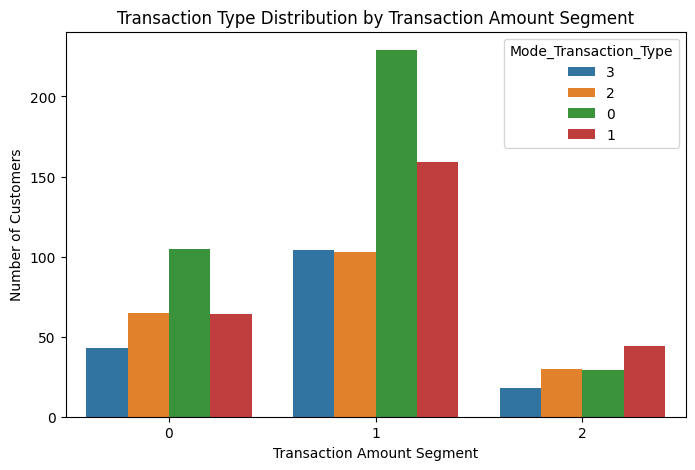

In [ ]:
# Transaction amount vs transaction type


plt.figure(figsize=(8,5))
sns.countplot(data=customer_data,
              x='Mode_Transaction_Amount_Segment',
              hue='Mode_Transaction_Type')
plt.title("Transaction Type Distribution by Transaction Amount Segment")
plt.xlabel("Transaction Amount Segment")
plt.ylabel("Number of Customers")
plt.show()

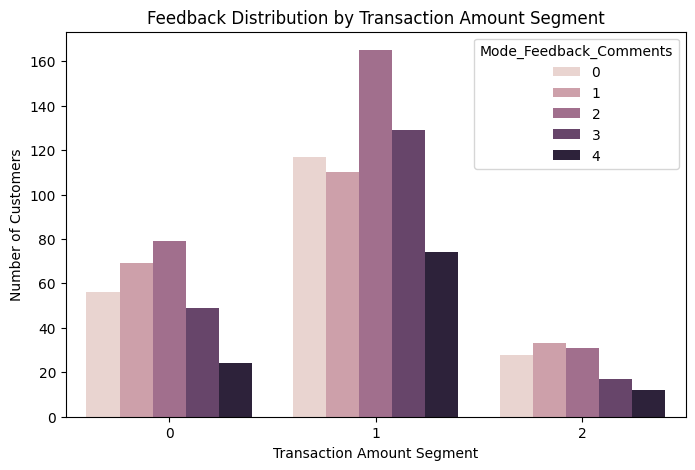

In [ ]:
#Feedback by transaction amount (0=low satisfaction)

plt.figure(figsize=(8,5))
sns.countplot(data=customer_data,
              x='Mode_Transaction_Amount_Segment',
              hue='Mode_Feedback_Comments')
plt.title("Feedback Distribution by Transaction Amount Segment")
plt.xlabel("Transaction Amount Segment")
plt.ylabel("Number of Customers")
plt.show()

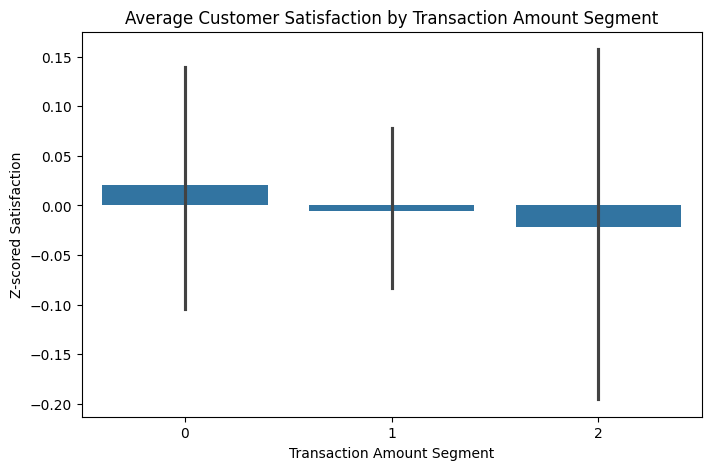

In [ ]:
# Transaction amount vs satisfaction score
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=customer_data,
    x='Mode_Transaction_Amount_Segment',
    y='Avg_Satisfaction_Score'
)

plt.title("Average Customer Satisfaction by Transaction Amount Segment")
plt.xlabel("Transaction Amount Segment")
plt.ylabel("Z-scored Satisfaction")
plt.show()


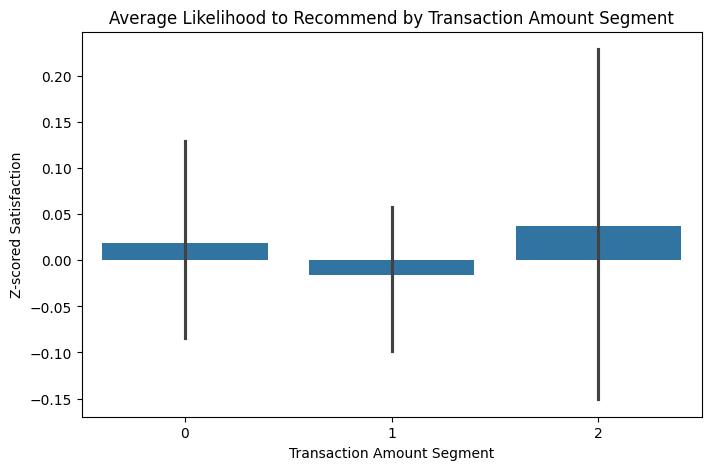

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=customer_data,
    x='Mode_Transaction_Amount_Segment',
    y='Avg_Likelihood_to_Recommend'
)

plt.title("Average Likelihood to Recommend by Transaction Amount Segment")
plt.xlabel("Transaction Amount Segment")
plt.ylabel("Z-scored Satisfaction")
plt.show()
